## Dataframe API Concepts
- Subsetting DataFrames (select, filter, etc.)
- Column manipulation (casting, creating columns, manipulating existing columns, complex column types)
- String manipulation (Splitting strings, regular expressions)
- Performance-based operations (repartitioning, shuffle partitions, caching)
- Combining DataFrames (joins, broadcasting, unions, etc.)
- Reading/writing DataFrames (schemas, overwriting)
- Working with dates (extraction, formatting, etc.)
- Aggregations
- Miscellaneous (sorting, missing values, typed UDFs, value extraction, sampling)


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, stddev
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf, SQLContext
import os

spark = (SparkSession
         .builder
         .appName("spark-programming-overview")
         .master("spark://spark-master:7077")
         .config("spark.executor.memory", "1024m")
         .getOrCreate())

In [2]:
df = spark.read.csv("co-est2019-alldata.csv", header=True)

In [3]:
df.toPandas().head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,040,3,6,01,000,Alabama,Alabama,4779736,4780125,4785437,...,1.9175014754,0.5784335677,1.1863137707,1.5225486174,0.5634892079,0.6263573914,0.7451724354,1.0903664003,1.7737864964,2.4837435218
1,050,3,6,01,001,Alabama,Autauga County,54571,54597,54773,...,4.8473097431,6.0181818182,-6.226118841,-3.902225545,1.9704433498,-1.712874805,4.777171297,0.8496560701,0.5409157704,4.5600617583
2,050,3,6,01,003,Alabama,Baldwin County,182265,182265,183112,...,24.017828601,16.641869776,17.488578535,22.751473911,20.184333668,17.725963762,21.27929069,22.398255745,24.727215272,24.380567187
3,050,3,6,01,005,Alabama,Barbour County,27457,27455,27327,...,-5.690302272,0.2926757884,-6.897816914,-8.13218497,-5.140430604,-15.72457483,-18.2380157,-24.99852834,-8.754922145,-5.165664474
4,050,3,6,01,007,Alabama,Bibb County,22915,22915,22870,...,1.3851343804,-4.998355804,-3.787545142,-5.797999469,1.3311443404,1.3298167069,-0.708717222,-3.234668557,-6.85709197,1.8319519224


In [4]:
stateDF = (df.withColumn("CENSUS2010POP", df["CENSUS2010POP"].cast(IntegerType()))
  .select("STNAME","CENSUS2010POP")
  .where("SUMLEV = 040 and CENSUS2010POP > 100000")
  .orderBy(col("CENSUS2010POP").desc())
  .withColumnRenamed('STNAME', 'State')
  .withColumnRenamed('CENSUS2010POP', 'Population')
)

In [5]:
stateDF.select("Population").count()

51

In [6]:
stateDF.agg(sum("Population"),stddev("Population")).collect()

[Row(sum(Population)=308745538, stddev_samp(Population)=6823984.2713947)]

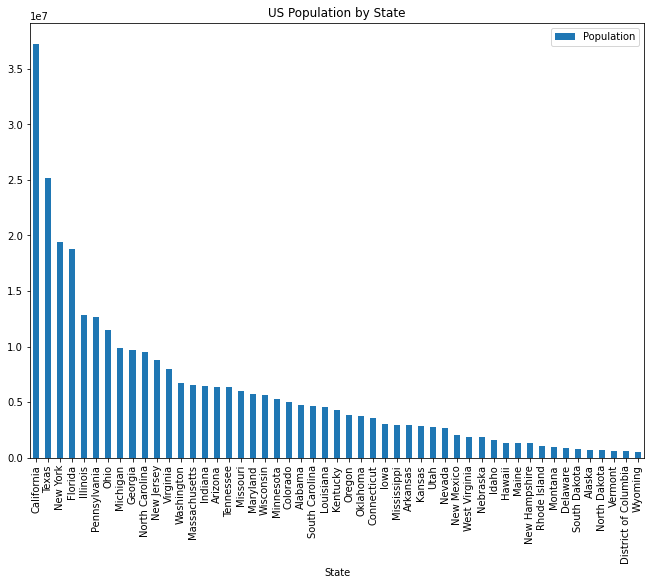

In [7]:
stateDF.toPandas().plot.bar(x="State",figsize=(11,8), title="US Population by State")
plt.show()

In [8]:
import boto3
from botocore.client import Config

s3 = boto3.resource('s3',
                    endpoint_url=os.getenv('MLFLOW_S3_ENDPOINT_URL'),
                    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
                    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
                    config=Config(signature_version='s3v4'),
                    region_name=os.getenv('AWS_DEFAULT_REGION'))

In [9]:
s3.Bucket('data').download_file('tft.csv', '/opt/workspace/tft.csv')

In [10]:
tdf=spark.read.csv("tft.csv", header=True)

In [11]:
tdf.toPandas().head()

,short_name,platform_id
0,LTI,310638
1,LTI,311802
2,LTI,10314466
3,MDI,10314568
4,LTI,10314700


In [12]:
!ls

 1kings.txt			      noaa-weather-data-jfk-airport.tar.gz
'Testing Cluster.ipynb'		      outputs
 a2_w1_s3_ETL.ipynb		      pyspark.ipynb
 a6_w1_ex1.ipynb		      scala.ipynb
 a6_w4_assignment.ipynb		     'sherlock count.ipynb'
 airflow			      sherlock.txt
 co-est2019-alldata.csv		     'spark programming overview.ipynb'
 delta-example.ipynb		      sparkr.ipynb
 delta-test			      streaming.py
 dsas				      tft.csv
 health_profile_data.snappy.parquet   tmp.sh
 iris.data			      user_profile_data.snappy.parquet
'mlflow test.ipynb'		      usr
 noaa-weather-data-jfk-airport	      wordcount.py


In [13]:
s3.Bucket('data').upload_file('sherlock.txt','sherlock.txt')

In [2]:
spark.stop()